# Text Classification
## 
## 
- **Overview**: For this assignment, we’ll be building a text classifier. The goal of our text classifer will be to distinguish between words that are simple and words that are complex. Example simple words are `heard`, `sat`, and `town`, and example complex words are `abdicate`, `detained`, and `vintners`. Distinguishing between simple and complex words is the first step in a larger NLP task called text simplification, which aims to replace complex words with simpler synonyms. Text simplification is potentially useful for re-writing texts so that they can be more easily understood by younger readers, people learning English as a second language, or people with learning disabilities.

- **Learning goals**:
    - Understand an important class of NLP evaluation methods (precision, recall and F1), and implement them yourself.
    - Employ common experimental design practices in NLP. Split the annotated data into training/development/test sets, implement simple baselines to determine how difficult the task is, and experiment with a range of features and models.
    - Get an introduction to `sklearn`, an excellent machine learning Python package.

- **Data**: We will provide you with training and development data that has been manually labeled. We will also give you a test set without labels. You will build a classifier to predict the labels on our test set. You can upload your classifier’s predictions to Gradescope. We will score its predictions and maintain a leaderboard showing whose classifier has the best performance.

## Recommended Readings
- [Naive Bayes Classification and Sentiment](https://web.stanford.edu/~jurafsky/slp3/4.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft).
- [Logistic Regression](https://web.stanford.edu/~jurafsky/slp3/5.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft) .
- [Problems in Current Text Simplification Research: New Data Can Help](http://www.cis.upenn.edu/~ccb/publications/new-data-for-text-simplification.pdf) Wei Xu, Chris Callison-Burch, and Courtney Napoles. TACL 2015.
- [Comparison of Techniques to Automatically Identify Complex Words](http://aclweb.org/anthology/P/P13/P13-3015.pdf) Matthew Shardlow. ACL 2013.
- [SemEval 2016 Task 11: Complex Word Identification](https://www.researchgate.net/profile/Gustavo_Paetzold/publication/305334627_SemEval_2016_Task_11_Complex_Word_Identification/links/57bab70a08ae14f440bd9722/SemEval-2016-Task-11-Complex-Word-Identification.pdf) Gustavo Paetzold and Lucia Specia. ACL 2016.

## Setup 1: PennGrader Setup

In [ ]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client dill

In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting notebook-config.yaml


In [ ]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [ ]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 36181310 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW2', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 36181310

Make sure this correct or we will not be able to store your grade


In [ ]:
def reload_grader():
    grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW2', STUDENT_ID, SECRET)
    return grader

In [ ]:
# check if the PennGrader is set up correctly
# do not chance this cell, see if you get 4/4!
name_str = 'Anyta Ali'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**
- [Loading dataset from huggingface](https://huggingface.co/docs/datasets/v1.8.0/loading_datasets.html#from-local-files)

In [ ]:
from collections import defaultdict
import gzip

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np
from tqdm import tqdm
from dill.source import getsource
import matplotlib.pyplot as plt
from pprint import pprint

In [ ]:
#%%capture
# data
!gdown 16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ # https://drive.google.com/file/d/16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ/view?usp=sharing
!gdown 17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk # https://drive.google.com/file/d/17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk/view?usp=sharing
!gdown 1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK # https://drive.google.com/file/d/1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!curl -L -o ngram_counts.txt.gz http://www.cis.upenn.edu/~cis5300/18sp/data/ngram_counts.txt.gz

Downloading...
From: https://drive.google.com/uc?id=16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 70.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 83.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 1.43MB/s]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   272  100   272    0     0    522      0 --:--:-- --:--:-- --:--:--   522
100 42.4M  100 42.4M    0     0  7751k      0  0:00:05  0:00:05 --:--:-- 9951k


In [ ]:
!gdown 1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s

Downloading...
From (original): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s
From (redirected): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s&confirm=t&uuid=5f4a2307-7bec-4217-9d38-2a5bf63a5528
To: /content/ngram_counts.txt.gz
100% 44.5M/44.5M [00:00<00:00, 177MB/s]


In [ ]:
train_file = "complex_words_training.txt"
dev_file = "complex_words_development.txt"
test_file = "complex_words_test_unlabeled.txt"
mini_test_file = 'complex_words_test_mini.txt'

In [ ]:
########## DO NOT CHANGE ##########
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

def load_unlabeled_file(data_file):
    words = []
    # labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        words = [line.strip() for line in f.readlines() if len(line.strip()) > 0]
    return words

def load_test_file(data_file):
    words = []
    with open(data_file, 'rt', encoding="utf8") as f:
        next(f) # skip first line (header)
        words = [line.strip().split('\t')[0] for line in f.readlines() if len(line.strip()) > 0]
    return words

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file = 'ngram_counts.txt.gz'):
    counts = defaultdict(int)
    with gzip.open(ngram_counts_file, 'rt') as f:
        for line in f:
            token, count = line.strip().split('\t')
            if token[0].islower():
                counts[token] = int(count)
    return counts
ngram_counts = load_ngram_counts()

### About the data
- `train_data`, `dev_data`: these are words with labels, provided for you to train and evaluate your models.
- `mini_test_words`: this is a subset (50) of the unseen test dataset, we will provide test the **basic functionality** of your models based on the performance on this mini testset (PennGrader tests). **This would only be a basic sanity check of your implementation. The final grade would be based on the PennGrader Grades and manual grading on your implementation**
- `test_words`: this is the full, unlabelled test set. You are expected to submit the prediction of these words at the end of the assignment.

In [ ]:
########## DO NOT CHANGE ##########
train_data = load_labeled_file(train_file)
dev_data = load_labeled_file(dev_file)
mini_test_words = load_unlabeled_file(mini_test_file)
test_words = load_test_file(test_file)

# you can take a look at this mini-dev data by uncommenting this line
dev_words, dev_labels = dev_data
dev_words[:5] # some examples of this dev dataset
# dev_labels[:5]
# train_data[1:2][0]

['hammer', 'renewable', 'showings', 'academy', 'continues']

# Section 1. Implement the Evaluation Metrics
- You might find this [Wikipedia Page](https://en.wikipedia.org/wiki/Precision_and_recall) useful.
- **Problem 1.1** Predicion, Recall, F1 Score

In [ ]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_true, y_pred):
    tp = sum((yt == yp) and (yt == 1) for yt, yp in zip(y_true, y_pred))  # True Positives
    fp = sum((yt != yp) and (yp == 1) for yt, yp in zip(y_true, y_pred))  # False  Positives
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # to avoid division by zero
    return precision

## Calculates the recall of the predicted labels
def get_recall(y_true, y_pred):
    tp = sum((yt == yp) and (yt == 1) for yt, yp in zip(y_true, y_pred))  # True positives
    fn = sum((yt != yp) and (yt == 1) for yt, yp in zip(y_true, y_pred))  # False  Negatives
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # avoid division by zero
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    fscore = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # Avoid division by zero
    return fscore

In [ ]:
# PennGrader - DO NOT CHANGE
# grader.grade(test_case_id = 'test_q11_eval_funcs', answer = (get_precision, get_recall, get_fscore))
grader.grade(test_case_id = 'test_q11_eval_funcs', answer = [getsource(get_precision), getsource(get_recall), getsource(get_fscore)])

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2. Baselines

## 2.1 Implement a majority class baseline
You should start by implementing simple baselines as classifiers. Your first baseline is a **majority class baseline** which is one of the most simple classifier. You should complete the function `all_complex(words)`, which takes in a list of words, and returns out the predictions.


- **Problem 2.1:** Implement `all_complex()` that always predicts the majority class of the data (i.e. predicting every word as complex)

In [ ]:
## Labels every word complex
def all_complex(words):
    ## YOUR CODE HERE...
    y_pred = [1] * len(words)
    return y_pred

In [ ]:
import matplotlib.pyplot as plt

- **Answer 2.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[TODO]**
    - Development **[TODO]**

In [ ]:
## Evaluation of answer 2.1
def eval_complex(y_true, y_pred):
  precision = get_precision(y_true, y_pred)
  recall = get_recall(y_true, y_pred)
  fscore = get_fscore(y_true, y_pred)
  return precision, recall, fscore


## Load data train_data and dev_data
train_words, train_labels = train_data #tuple unpacking
dev_words, dev_labels = dev_data       # tuple unpacking

##  report the precision, recall, and f-score on both the training data and the development data
train_predictions = all_complex(train_words)
dev_predictions = all_complex(dev_words)

train_precision, train_recall, train_fscore = eval_complex(train_labels, train_predictions)
dev_precision, dev_recall, dev_fscore = eval_complex(dev_labels, dev_predictions)



##tuple unpacking
##dev_data = (["giraffe", "dog", "magnificent"], [1, 0, 1])
# dev_words, dev_labels = dev_data

# print(dev_words)   # Output: ['giraffe', 'dog', 'magnificent']
# print(dev_labels)  # Output: [1, 0, 1]

In [ ]:
import csv
## Test Cell
##this block is to view the train and data tuple

# Save dictionary as CSV
with open("ngram_counts.csv", "w", newline="") as f:
    writer = csv.writer(f)
    # Write data rows
    writer.writerows(ngram_counts)

print(len(dev_data))
print(len(train_data))

2
2


In [ ]:

y_pred = all_complex(dev_words)
precision = get_precision(dev_labels, y_pred)
recall = get_recall(dev_labels, y_pred)
fscore = get_fscore(dev_labels, y_pred)
fscore



## Print results
print("### Training Data Metrics ###")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")

print("\n### Development Data Metrics ###")
print(f"Precision: {dev_precision:.4f}")
print(f"Recall: {dev_recall:.4f}")
print(f"F1-score: {dev_fscore:.4f}")

### Training Data Metrics ###
Precision: 0.4328
Recall: 1.0000
F1-score: 0.6041

### Development Data Metrics ###
Precision: 0.4180
Recall: 1.0000
F1-score: 0.5896


In [ ]:
# PennGrader - DO NOT CHANGE
print(mini_test_words)
all_complex_pred = all_complex(mini_test_words)
grader.grade(test_case_id = 'test_baseline_q21', answer = all_complex_pred)

['threads', 'reinforce', 'letters', 'pioneered', 'closer', 'fruits', 'gems', 'participants', 'tools', 'independent', 'rushed', 'physics', 'volume', 'box-office', 'warn', 'sorts', 'allegiance', 'hitchhiker', 'boring', 'celebrate', 'stranded', 'extra', 'expecting', 'steam', 'decide', 'flown', 'gunmen', 'murder', 'soldiers', 'purchasing', 'confined', 'lowered', 'participated', 'lady', 'fishes', 'acclaim', 'taste', 'highs', 'ordinary', 'finish', 'jewelry', 'seeing', 'skydive', 'already', 'instill', 'judges', 'aims', 'deep', 'fragment', 'right']
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


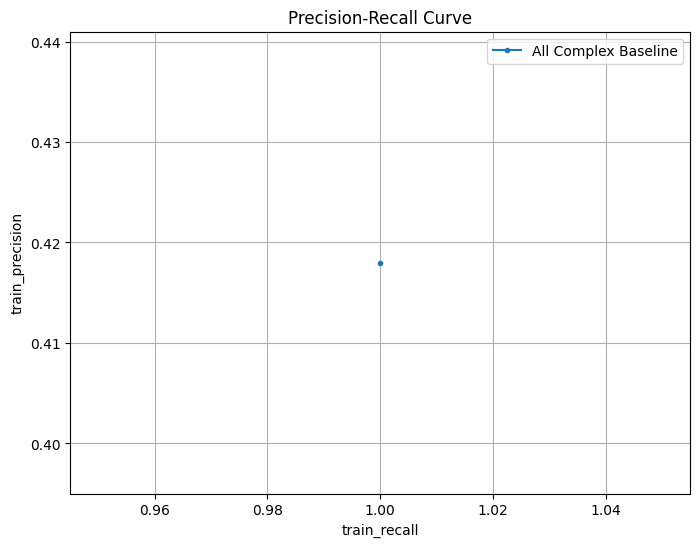

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label="All Complex Baseline")
plt.xlabel("train_recall")
plt.ylabel("train_precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


## 2.2 Word length baseline
For our next baseline, we will use a slightly complex baseline, the length of each word to predict its complexity.

For the word length baseline, you should try setting various thresholds for word length to classify them as simple or otherwise. For example, you might set a threshold of 9, meaning that any words with less than 9 characters will be labeled simple, and any words with 9 characters or more will be labeled complex. Once you find the best threshold using the training data, use this same threshold for the development data as well.

You will be filling in the function `word_length_threshold(train_data, dev_data)`. This function takes in both the training and development datasets, finds the best threshold on word length and returns out the predictions on development data for your best threshold.

Usually, Precision and Recall are inversely related and while building binary-classification systems we try to find a good balance between them (by maximizing f-score, for example). It is often useful to plot the Precision-Recall curve for various settings of the classifier to gauge its performance and compare it to other classifiers. For example, for this baseline, a Precision-Recall curve can be plotted by plotting the Precision (on the y-axis) and Recall (on the X-axis) for different values of word-length threshold.

- **Problem 2.2:** Implement `word_length_threshold()` that finds the best word length threshold and makes predictions on the development (or testing) data.

train_words = ["simple", "complicated", "difficult", "easy", "basic"]
train_labels = [0, 1, 1, 0, 0]  # True labels

Using threshold = 6
predictions =  [0, 1, 0, 0, 0]  # Our predictions

In [ ]:
### 2.2: Word length thresholding
## Makes feature matrix for word_length_threshold
## word length
def length_threshold_feature(words, threshold):
    # return predictions based on the threshold
    """
    Make predictions based on word length threshold
    Args:
        words: List of words to classify ["simple", "complicated", "difficult", "easy", "basic"]
        threshold: Integer threshold for word length
    Returns:
        List of predictions (1 for complex, 0 for simple) i.e. predictions = [0, 1, 0, 0, 0]
    """
    predictions =[]
    for word in words:
      if len(word) >= threshold:
        predictions.append(1) #complex words
      else:
        predictions.append(0)

    return predictions #list of labels predicted for words

def find_best_threshold(train_words, train_labels):
    """
    Finds the best word length threshold based on F1-score.

    Args:
        train_words (list of str): Training words.
        train_labels (list of int): Ground truth labels (0 = simple, 1 = complex).

    Returns:
        int: Best threshold value.
    """
    lengths_list = map(len, train_words) # map length
    max_lenght = max(lengths_list) # find maximum
    thresholds = range(1, max_lenght + 1 ) # Create range
    best_threshold = None
    best_f1 = 0

    for threshold in thresholds: # Try thresholds from 1 to max word length
        predictions = length_threshold_feature(train_words, threshold)
        f1 = get_fscore(train_labels, predictions)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold



## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
## use zip function zip(predictions, true_labels) pairs up each prediction with its true label
def word_length_threshold(train_data, dev_words):
    """
    writing this Finds the best length threshold using training data and applies it to classify dev data.

    Args:
        train_data (tuple): (train_words, train_labels).
        dev_words (list of str): Development words.

    Returns:
        list of int: Predictions on development data.
    """
    twords, tlabels = train_data       # tuple unpacking
    best_threshold = find_best_threshold(train_words, train_labels)
    print(f"Best Threshold : {best_threshold:.4f}")
    ## YOUR CODE HERE
    dev_pred = length_threshold_feature(dev_words, best_threshold)
    return dev_pred

- **Answer 2.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Range of thresholds **[TODO]**
    - Training **[TODO]**
    - Development **[TODO]**
    - Precision-recall Curve **[Plot below]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [ ]:
dev_words, dev_labels = dev_data
y_pred = word_length_threshold(train_data, dev_words)
dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)
dfscore


print("\n### Data Metrics ###")
print(f"Precision: {dprecision:.4f}")
print(f"Recall: {drecall:.4f}")
print(f"F1-score: {dfscore:.4f}")


train_words, train_labels = dev_data
y_pred = word_length_threshold(train_data, train_words)
tprecision = get_precision(dev_labels, y_pred)
trecall = get_recall(dev_labels, y_pred)
tfscore = get_fscore(dev_labels, y_pred)

print("\n### Data Metrics - Training ###")
print(f"Precision: {tprecision:.4f}")
print(f"Recall: {trecall:.4f}")
print(f"F1-score: {tfscore:.4f}")


Best Threshold : 7.0000

### Data Metrics ###
Precision: 0.6054
Recall: 0.8660
F1-score: 0.7126
Best Threshold : 7.0000

### Data Metrics - Training ###
Precision: 0.6054
Recall: 0.8660
F1-score: 0.7126


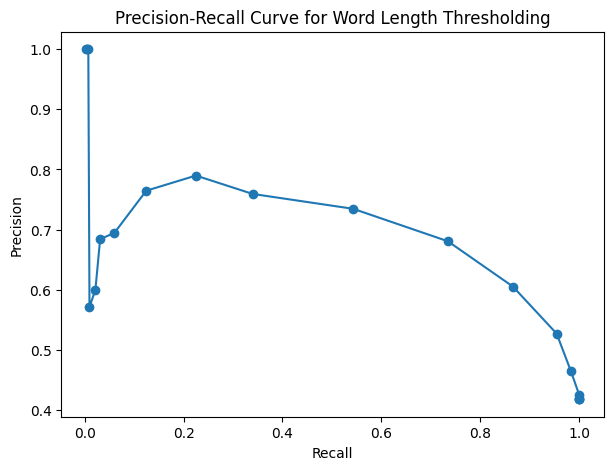

In [ ]:
## TODO
# precision-recall curve goes here
def plot_precision_recall(train_words, train_labels):
    """
    Plots Precision-Recall curve for different word length thresholds.

    Args:
        train_words (list of str): Training words.
        train_labels (list of int): Ground truth labels.
    """
    thresholds = range(1, max(map(len, train_words)) + 1)
    precisions = []
    recalls = []

    for threshold in thresholds:
        predictions = length_threshold_feature(train_words, threshold)
        precision = get_precision(train_labels, predictions)
        recall= get_recall(train_labels, predictions)
        precisions.append(np.mean(precision))
        recalls.append(np.mean(recall))

    # Plot PR Curve
    plt.figure(figsize=(7,5))
    plt.plot(recalls, precisions, marker="o", linestyle="-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for Word Length Thresholding")
    plt.show()

 # Plot PR Curve
plot_precision_recall(train_words, train_labels)

In [ ]:
# PennGrader - DO NOT CHANGE
word_length_pred = word_length_threshold(train_data, mini_test_words)
grader.grade(test_case_id = 'test_baseline_q22', answer = word_length_pred)

Best Threshold : 7.0000
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.3 Word frequency baseline


Our final baseline is a classifier similar to the last one, but thresholds on word frequency instead of length. We have provided Google NGram frequencies in the text file ngram_counts.txt, along with the helper function `load_ngram_counts(ngram_counts_file)` to load them into Python as a dictionary.

You will be filling in the function `word_frequency_threshold(train_data, dev_data, ngram_counts)`, where `ngram_counts` is the dictionary of word frequencies. This function again finds the best threshold and returns predictions on the development data.

Please again report the precision, recall, and f-score on the training and development data individually, along with the range of thresholds you tried, and the best threshold to be graded. Similar to the previous baseline, plot the Precision-Recall curve for range of thresholds you tried. Compared with word length baseline, which classifier looks better on average?

**Note: Due to its size, loading the ngram counts into Python takes around 20 seconds, and finding the correct threshold may take a few minutes to run.**

- **Problem 2.3:** Implement `word_frequency_threshold()` that finds the best word frequency threshold and makes predictions on the development (or testing) data.

In [ ]:
## Make feature matrix for word_frequency_threshold
def frequency_threshold_feature(words, threshold, ngram_counts):
    # return predictions based on the threshold
    ## YOUR CODE HERE
    # hint: check the content of `ngram_counts` variable
    # Feature: Is frequency < 200? (1 if yes = complex word, 0 if no = simple word)
    '''
    predictions = [
        0,  # cat (freq=500): above threshold = simple
        1,  # extraordinary (freq=50): below threshold = complex
        0,  # dog (freq=600): above threshold = simple
        1   # sophisticated (freq=30): below threshold = complex
    ]
    '''
    predictions = [1 if ngram_counts.get(word, 0) < threshold else 0 for word in words]
    # for word in words:
    #   #find the frequency of the word in ngram_count, if word is not found return 0
    #   frequency = ngram_counts.get(word.lower(), 0 )
    #   if frequency < threshold:
    #     predictions.append(1) # complex word - its used rarely
    #   else:
    #     predictions.append(0) # simple word
    return predictions


def word_frequency_threshold(train_data, dev_words, ngram_counts):
    twords, tlabels = train_data

    ## YOUR CODE HERE
    # Getting all unique frequencies from training data
    frequencies = set()
    for word in twords:
        freq = ngram_counts.get(word.lower(), 0)
        frequencies.add(freq)

    # Trying each frequency as threshold to find best one

    best_threshold = 0
    best_fscore = 0

    for threshold in sorted(frequencies):
        # Get predictions for current threshold
        train_predictions = frequency_threshold_feature(twords, threshold, ngram_counts)

        # # Calculate metrics
        fscore = get_fscore(tlabels, train_predictions)

        # Update best threshold if we get better f-score
        if fscore > best_fscore:
            best_fscore = fscore
            best_threshold = threshold

    # Use best threshold to make predictions on development data
    dev_pred = frequency_threshold_feature(dev_words, best_threshold, ngram_counts)

    return dev_pred #, precisions, recalls, thresholds

In [ ]:

# print(type(ngram_counts))
# next(iter(ngram_counts))
#pprint(ngram_counts)
# take(10, ngram_counts.items())

- **Answer 2.3:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Range of thresholds **[TODO]**
    - Training **[TODO]**
    - Development **[TODO]**
    - Precision-recall Curve **[Plot below]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [ ]:
dev_words, dev_labels = dev_data
y_pred  = word_frequency_threshold(train_data, dev_words, ngram_counts)

dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)
dfscore

#Calculate metrics for training data
twords, tlabels = train_data
t_y_prediction = word_frequency_threshold(train_data, twords, ngram_counts)
tprecision = get_precision(tlabels, t_y_prediction)
trecall = get_recall(tlabels, t_y_prediction)
tfscore = get_fscore(tlabels, t_y_prediction)



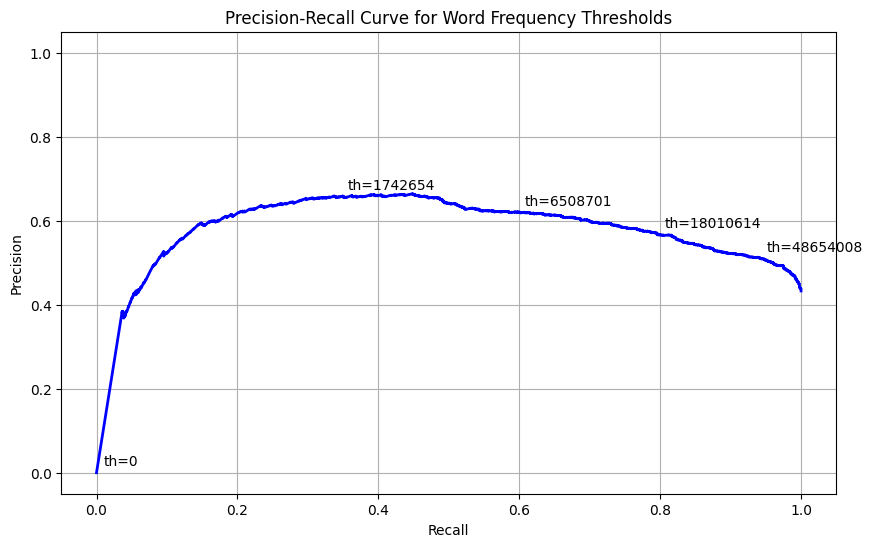

In [ ]:
# Create a separate function for PR curve data
def get_pr_curve_data(train_data, ngram_counts):
    dev_words, dev_labels = dev_data

    frequencies = set()
    for word in twords:
        freq = ngram_counts.get(word.lower(), 0)
        frequencies.add(freq)

    precisions = []
    recalls = []
    thresholds = []

    for threshold in sorted(frequencies):
        train_predictions = frequency_threshold_feature(twords, threshold, ngram_counts)
        precision = get_precision(tlabels, train_predictions)
        recall = get_recall(tlabels, train_predictions)

        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(threshold)

    return precisions, recalls, thresholds

def plot_pr_curve(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 6))
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Word Frequency Thresholds')
    plt.grid(True)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)

    # Add some threshold annotations
    for i in range(0, len(thresholds), len(thresholds)//5):
        plt.annotate(f'th={thresholds[i]}',
                    (recalls[i], precisions[i]),
                    xytext=(5, 5), textcoords='offset points')

    plt.show()

precisions, recalls, thresholds = get_pr_curve_data(train_data, ngram_counts)
plot_pr_curve(precisions, recalls, thresholds)

In [ ]:
    # print("\nResults with best threshold:", best_threshold)
print("\nTraining Data Metrics:")
print(f"Precision: {tprecision:.3f}")
print(f"Recall: {trecall:.3f}")
print(f"F-score: {tfscore:.3f}")

print("\nDevelopment Data Metrics:")
print(f"Precision: {dprecision:.3f}")
print(f"Recall: {drecall:.3f}")
print(f"F-score: {dfscore:.3f}")


Training Data Metrics:
Precision: 0.566
Recall: 0.816
F-score: 0.668

Development Data Metrics:
Precision: 0.557
Recall: 0.844
F-score: 0.671


In [ ]:
# PennGrader - DO NOT CHANGE
word_freq_pred = word_frequency_threshold(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_baseline_q23', answer = word_freq_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
print(word_freq_pred)

[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


# Section 3. Classifiers

## 3.1 Naive Bayes classification


Now, let’s move on to actual machine learning classifiers! For our first classifier, you will use the built-in [Naive Bayes model from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), to train a classifier. You should refer to the online sklearn documentation when you are building your classifier.

The first thing to note is that sklearn classifiers take in `numpy` arrays, rather than regular lists. You may use the [online numpy documentation](https://numpy.org/doc/stable/). To create a `numpy` list of length 5, you can use the following Python commands:

```
import numpy as np
X = np.array([1,2,3,4,5])
```


To train a classifier, you need two numpy arrays: `X_train`, an `m` by `n` array, where `m` is the number of words in the dataset, and `n` is the number of features for each word; and `Y`, an array of length `m` for the labels of each of the words.

**Before we start training models, we need to convert our texts/words into numpy arrays, i.e. making training/testing feature vectors.**

- **Problem 3.0**: Implementing `get_training_features()` and `get_test_features()` that convert train/test dataset to numpy arrays

In [ ]:
%%capture
# run the following cell if you want to use count of syllabus as a feature
!pip install syllables
import syllables

In [ ]:
def get_training_features(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        ## YOUR CODE HERE
        word_features = []
        vowels = 'aeiouy'
        count = 0
        prev_char_is_vowel = False
        # 1. word length feature
        word_features.append(len(word))
        # 2. unigram frequency feature
        frequency = ngram_counts.get(word.lower(), 0)
        word_features.append(frequency)
        # 3. (optional) syllables count feature
        word = word.lower()
        vowels = 'aeiouy'
        count = 0
        previous_char_was_vowel = False

        # Handle special case of 'e' at end
        if word.endswith('e'):
            word = word[:-1]

        # Count syllables
        for char in word:
            is_vowel = char in vowels
            if is_vowel and not previous_char_was_vowel:
                count += 1
            previous_char_was_vowel = is_vowel

        syllables = max(1, count)  # ensure at least one syllable

        word_features.append(syllables)


        features.append(word_features)
    #print(features)
    X = np.asarray(features)
    ## YOUR CODE HERE
    # TODO: calculate the mean and std of the vectorized data (X)
    means = np.mean(X, axis=0)  # Mean of each column
    stds = np.std(X, axis=0)   # Std of each column

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds

    Y = np.asarray(y_true)
    return X_scaled, Y, means, stds

def get_test_features(dev_words, ngram_counts, means, stds):

    ## YOUR CODE HERE
    features = []

    # Extract same features as training
    for word in dev_words:
        word_features = []
        # 1. word length feature
        word_features.append(len(word))
        # 2. unigram frequency feature
        frequency = ngram_counts.get(word.lower(), 0)
        word_features.append(frequency)

                # 3. syllables count feature - EXACTLY same logic as training
        word = word.lower()
        vowels = 'aeiouy'
        count = 0
        previous_char_was_vowel = False

        if word.endswith('e'):
            word = word[:-1]

        for char in word:
            is_vowel = char in vowels
            if is_vowel and not previous_char_was_vowel:
                count += 1
            previous_char_was_vowel = is_vowel

        syllables = max(1, count)
        word_features.append(syllables)

        features.append(word_features)

    X = np.asarray(features)
    # TODO: do the similar thing, except using means and stds as given (from training data)
    X_scaled = (X - means) / stds

    return X_scaled

In [ ]:
# PennGrader - DO NOT CHANGE
dev_words, dev_labels = dev_data
X_train, Y_train, means, stds = get_training_features(train_data, ngram_counts)
X_dev = get_test_features(dev_words, ngram_counts, means, stds)

train_feats = (X_train, Y_train, means, stds)
test_feats = (X_dev)

grader.grade(test_case_id = 'test_q30_test_feature_shapes', answer = (train_feats, test_feats))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once we have these feature arrays, we can fit a Naive Bayes classifier using the following commands:
```
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, Y)
```
Finally, to use your model to predict the labels for a set of words, you only need one numpy array: `X_test`, an `m` by `n` array, where `m` is the number of words in the test set, and `n` is the number of features for each word. Note that the `n` used here is the same as the `n` in `X_train`. Then, we can use our classifier to predict labels using the following command:

```
Y_pred = clf.predict(X_test)
```

- **Problem 3.1**: Fill in the function `naive_bayes(train_data, dev_data, ngram_counts)`. This function will train a Naive Bayes classifier on the training data using **word length** and **word frequency** as features, and returns your model’s predictions on the training data and the development data individually.
    - **NOTE**: Before training and testing a classifier, it is generally important to normalize your features. This means that you need to find the mean and standard deviation (sd) of a feature. Then, for each row, perform the following transformation: `X_scaled = (X_original - mean)/sd`. **Be sure to always use the means and standard deviations from the training data**.
    - **Optional**: You can include more features if you want to, e.g. [the count of syllabus](https://github.com/prosegrinder/python-syllables)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [ ]:
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(train_data, dev_words, ngram_counts):
    # TODO
    # 1. Gets the features from the training data, and trains the model
    X_train_scaled, Y_train, means, stds = get_training_features(train_data, ngram_counts)
    # 2. Train model & inference on dev_words
    ## YOUR CODE HERE
    clf = GaussianNB()
    clf.fit(X_train_scaled, Y_train)

    # 3. Get predictions on training data
    train_pred = clf.predict(X_train_scaled)

    # 4. Get features from dev data using same scaling parameters
    dev_words, dev_labels = dev_data
    X_dev_scaled = get_test_features(dev_words, ngram_counts, means, stds)

    # 5. Get predictions on dev data
    dev_pred = clf.predict(X_dev_scaled)

    return train_pred, dev_pred

- **Answer 3.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[TODO]**
    - Development **[TODO]**

In [ ]:
# report development metrics!
dev_words, dev_labels = dev_data
train_pred, dev_pred = naive_bayes(train_data, dev_words, ngram_counts)
dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
dev_f

# report train/development metrics!
# For training data metrics
train_words, train_labels = train_data  # get training labels
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_f = get_fscore(train_labels, train_pred)

In [ ]:
    # print("\nResults with best threshold:", best_threshold)
print("\nTraining Data Metrics:")
print(f"Precision: {dev_precision:.3f}")
print(f"Recall: {dev_recall:.3f}")
print(f"F-score: {dev_f:.3f}")

print("\nDevelopment Data Metrics:")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F-score: {train_f:.3f}")


Training Data Metrics:
Precision: 0.482
Recall: 0.971
F-score: 0.644

Development Data Metrics:
Precision: 0.506
Recall: 0.978
F-score: 0.667


In [ ]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = naive_bayes(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_naive_bayes', answer = mini_test_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.2 Logistic Regression
Next, you will use sklearn’s built-in Logistic Regression classifier. Again, we will use word length and word frequency as your two features. You should refer to [the online sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) when you are building your classifier. To import and use this model, use the following command:

```
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
```

- **Problem 3.2**: For this problem, you will be filling in the function `logistic_regression(train_data, dev_data, ngram_counts)`. This function will train a `Logistic Regression` classifier on the training data, and returns your model’s predictions on the training data and the development data individually.


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
## Trains a logistic regression classifier using length and frequency features
def logistic_regression(train_data, dev_words, ngram_counts):
    ## TODO
    # Get training features and labels
    X_train_scaled, Y_train, means, stds = get_training_features(train_data, ngram_counts)

    # Get dev features (using same scaling from training)
    X_dev_scaled = get_test_features(dev_words, ngram_counts, means, stds)

    lr = LogisticRegression(random_state=42)  # for reproducibility

    # Train model
    lr.fit(X_train_scaled, Y_train)

    # Get predictions
    train_pred = lr.predict(X_train_scaled)  # predictions on training data
    dev_pred = lr.predict(X_dev_scaled)      # predictions on dev data

    return train_pred, dev_pred

- **Answer 3.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[TODO]**
    - Development **[TODO]**

In [ ]:
dev_words, dev_labels = dev_data
train_pred, dev_pred = logistic_regression(train_data, dev_words, ngram_counts)
dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
dev_f

print("--- Training Metrics: --- ")
print(f"Precision: {dev_precision:.3f}")
print(f"Recall: {dev_recall:.3f}")
print(f"F-score: {dev_f:.3f}")

# Get predictions
train_pred, dev_pred = logistic_regression(train_data, dev_words, ngram_counts)

# Calculate metrics
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_fscore = get_fscore(train_labels, train_pred)

print("--- Training Metrics: ---")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F-score: {train_fscore:.3f}")

--- Training Metrics: --- 
Precision: 0.745
Recall: 0.651
F-score: 0.695
--- Training Metrics: ---
Precision: 0.728
Recall: 0.634
F-score: 0.678


In [ ]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = logistic_regression(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_logistic', answer = mini_test_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.3 Comparing Naive Bayes and Logistic Regression
- **Answer 3.3**: After implementing Naive Bayes and Logistic Regression classifiers, you will notice that their performance is not identical, even though they are given the same data. **Write a paragraph below that discusses which model performed better on this task and what are the potential reasons.**
    - [TODO: discussion of the differences]

# Answer 3.3



```
Naive Bayes:
Training: Precision=0.482, Recall=0.971, F-score=0.644
Dev: Precision=0.506, Recall=0.978, F-score=0.667

Logistic Regression:
Training: Precision=0.745, Recall=0.651, F-score=0.695
Dev: Precision=0.728, Recall=0.634, F-score=0.678
```



## Comparison of Naive Bayes and logistic Regression

Naive Bayes :  to more true positives (high recall) but also more false positives (low precision).
Naive Bayes modal achives very high recall i.e. 0.97 but with a lower precision i.e. 0.56, this shows that Naive Bayes successfully identifies most complex words but tends to overclassify simple words. This usually happens with a class imbalance, which leads to higher recall but at the cost of precision.

In Contrast, Logistic Regression has higher precision so it makes a fewer false positive predictions.
and a lower recalls indicate that it misses more actual positives compared to Naive Bayes.

Which modal is best depends on the use case, lets say this data is related to complaints regarding department or product; in that case, catching all relevant complex text is important, hence Naive Bayes. but if its a medical or legal document where classification (high precision) is important, then logistic Regression.



# Section 4. Build your own model
Finally, the fun part! In this section, you will build your own classifier for the complex word identification task, and compare your results to that of your classmates. You will also perform an error analysis for your best performing model.

You can choose any other types of classifier, and any additional features you can think of!
- For classifiers, beyond `Naive Bayes` and `Logistic Regression`, you might consider trying `SVM`, `Decision Trees`, and `Random Forests`, among others.
- Additional word features that you might consider include number of syllables, number of `WordNet` synonyms, and number of `WordNet` senses. To use WordNet in Python, refer to [this documentation](http://www.nltk.org/howto/wordnet.html).
- You could also include sentence-based complexity features, such as length of the sentence, average word length, and average word frequency.

When trying different classifiers, we recommend that you train on training data, and test on the development data, like the previous sections.

In the following cell, please include a description of **all of the models** and **features** that you tried. To receive full credit, you MUST try **at least 1 type of classifier** (not including `Naive Bayes` and `Logistic Regression`), and **at least two features** (not including length and frequency).

**Note**: You can also tune the parameters of your model, e.g. what type of kernel to use. This is NOT required, as some of you may not be that familiar with this.



## 4.1 Your Own Model

An important part of text classification tasks is to determine what your model is getting correct, and what your model is getting wrong. For this problem, you must train your best model on the training data, and report the precision, recall, and f-score on the development data. In order to receive full credit, your model must be able to outperform all of the baselines.

- **Answer 4.1**: Train your best model on the training data, and report the precision, recall, and f-score on the development data

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
def improve_ngram_features(ngram_counts, word):
    """
    Optimized feature extraction for n-gram frequencies
    """
    features = {}

    # 1. Log-transformed frequency (only for top n-grams)
    if word in ngram_counts:
        features["log_freq"] = np.log1p(ngram_counts[word])

    # 2. Word length features
    features["word_length"] = len(word)

    # 3. N-gram length features (only up to 3-grams for efficiency)
    for n in range(2, 4):
        ngrams = [word[i:i+n] for i in range(len(word)-n+1)]
        features[f'ngram_{n}_count'] = len(ngrams)

    return features


def get_training_features(train_data, ngram_counts):
    """
    Extracts optimized features for training data in sparse format.
    """
    words, labels = train_data

    # Extract features per word
    feature_dicts = [improve_ngram_features(ngram_counts, word) for word in words]

    # Collect all feature names
    feature_names = sorted(set(k for d in feature_dicts for k in d.keys()))

    # Convert to sparse matrix
    rows, cols, data = [], [], []
    for i, f_dict in enumerate(feature_dicts):
        for j, feat in enumerate(feature_names):
            if feat in f_dict:
                rows.append(i)
                cols.append(j)
                data.append(f_dict[feat])

    X_sparse = sp.csr_matrix((data, (rows, cols)), shape=(len(words), len(feature_names)))

    # Scale features
    scaler = StandardScaler(with_mean=False)  # Avoid memory explosion with sparse matrix
    X_scaled = scaler.fit_transform(X_sparse)

    return X_scaled, labels, scaler, feature_names


def get_test_features(test_words, ngram_counts, scaler, feature_names):
    """
    Extracts optimized features for test/dev data in sparse format.
    """
    feature_dicts = [improve_ngram_features(ngram_counts, word) for word in test_words]

    rows, cols, data = [], [], []
    for i, f_dict in enumerate(feature_dicts):
        for j, feat in enumerate(feature_names):
            if feat in f_dict:
                rows.append(i)
                cols.append(j)
                data.append(f_dict[feat])

    X_sparse = sp.csr_matrix((data, (rows, cols)), shape=(len(test_words), len(feature_names)))

    # Scale features using training scaler
    X_scaled = scaler.transform(X_sparse)

    return X_scaled


def svm_classifier(train_data, dev_data, ngram_counts):
    """
    Optimized SVM classifier with sparse features.
    """
    # Get optimized training features
    X_train_scaled, Y_train, scaler, feature_names = get_training_features(train_data, ngram_counts)

    # Get optimized dev features
    dev_words, dev_labels = dev_data
    X_dev_scaled = get_test_features(dev_words, ngram_counts, scaler, feature_names)

    # Train SVM
    svm = SVC(kernel='linear', C=1.0, class_weight='balanced')
    svm.fit(X_train_scaled, Y_train)

    # Predict on train and dev sets
    train_pred = svm.predict(X_train_scaled)
    dev_pred = svm.predict(X_dev_scaled)

    # Compute evaluation metrics
    dev_precision = precision_score(dev_labels, dev_pred)
    dev_recall = recall_score(dev_labels, dev_pred)
    dev_fscore = f1_score(dev_labels, dev_pred)

    print("\nDevelopment Data Metrics:")
    print(f"Precision: {dev_precision:.3f}")
    print(f"Recall: {dev_recall:.3f}")
    print(f"F1-score: {dev_fscore:.3f}")

    return train_pred, dev_pred

## 4.2 Analyze your model


Describe the model and features you choose, and perform a detailed error analysis of your models. Give several examples of words on which your best model performs well. Also give examples of words which your best model performs poorly on, and identify at least TWO categories of words on which your model is making errors.




- **Answer 4.2**: Write a detailed description of your model and features used. Also include error analysis of your model.

# Answer 4.2
## Modal Architect:
I have used SVM and default regelarization parameter C=1.0. Features are scaled using standarization.
Training features are scaled using mean and standard deviation.

# CORE FEATURES:
*   N-gram counts (Character Sequences)
*   Log of the frequency by applying logarithmic transformation to to reduce the impact of very large frequencies.
*   get the relative frequency counts to convert raw frequencies to proportions. this makes feature independent of corpus size
*   Feature Scaling applied using means and standard deviations.
*   Length feature to capture lenght related patterns.
*   Scaled Features: after features, I have used StandardScaler with mean to normalize the feratures.

# MODEL TRAINING
Converts feature vectors into sparse matrices (CSR format) to save memory.
and a my training modal is build using SVM classifier with a linear kernel.

Performance is evaluated using Precision, Recall, and F1-score.


# EVALUATION ANALYSIS
Analyze misclassifications by identifying False Positives (FPs) and False Negatives (FNs).


The model's performance on the development dataset is as follows:

Metric	Value
Precision	0.678
Recall	0.734
F1-Score	0.705
These values suggest that the model is reasonably good at distinguishing between simple (0) and complex (1) words, but there is room for improvement.

A precision of 67.8% of modal means that around 32.2% of words predicted as rare were actually common (false positives).

A recall of 73.4% of modal means that 26.6% of actual rare words were missed (false negatives)





## 4.3 Leaderboard
Finally, use your classifier to predict labels for the test data, and submit these labels in a text file named `test_labels.txt` (with one label per line) to the leaderboard; be sure NOT to shuffle the order of the test examples. Instructions for how to post to the leaderboard will be posted on Ed soon.
**In addition, the top 3 submissions will receive 5 bonus points! A successful submission to the leaderboard will guarantee 2 points!**

In [ ]:

train_pred, dev_pred = svm_classifier(train_data, dev_data, ngram_counts)

with open('test_labels.txt', 'w') as f:
    f.write("\n".join(map(str, train_pred)))


Development Data Metrics:
Precision: 0.678
Recall: 0.734
F1-score: 0.705


- **Answer 4.3**: Upload your `test_labels.txt` to the leaderboard in

---

Gradescope.

## 4.4. (Optional) Leaderboard using outside data

While the training data we have provided is sufficient for completing this assignment, it is not the only data for the task of identifying complex words. As an optional addition to this homework, you may look for and use any additional training data, and submit your predicted labels in a text file named `test_labels.txt` to the leaderboard.

As a start, we recommend looking at the [SemEval 2016 dataset](http://alt.qcri.org/semeval2016/task11/), a dataset that was used in a complex words identification competition. In addition, you can try to use data from [Newsela](https://newsela.com/). Newsela’s editors re-write newspaper articles to be appropriate for students at different grade levels. The company has generously shared a dataset with us. The Newsela data **may not** be re-distributed outside of Penn. You can find the data on eniac at `/home1/c/ccb/data/newsela/newsela_article_corpus_with_scripts_2016-01-29.1.zip`.

Good luck, and have fun!

# Submission
Here are the deliverables that you will need to submit:
- This notebook (rename them to `homework2.ipynb` and `homework2.py`)
- Your model’s output for the test set using only the provided training and development data (`test_labels.txt`)
- (Optional) your model’s output for the test set, using any data that you want. (`test_labels.txt`)